<img src = "https://github.com/barcelonagse-datascience/academic_files/raw/master/bgsedsc_0.jpg">
$\newcommand{\bb}{\boldsymbol{\beta}}$
$\DeclareMathOperator{\Gau}{\mathcal{N}}$
$\newcommand{\bphi}{\boldsymbol \phi}$
$\newcommand{\bx}{\boldsymbol{x}}$
$\newcommand{\bu}{\boldsymbol{u}}$
$\newcommand{\by}{\boldsymbol{y}}$
$\newcommand{\whbb}{\widehat{\bb}}$
$\newcommand{\hf}{\hat{f}}$
$\newcommand{\tf}{\tilde{f}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\E}{\mathbb{E}}$
$\newcommand{\Var}{Var}$
$\newcommand{\Cov}{Cov}$
$\newcommand{\Cor}{Cor}$

In [214]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

# Project: Linear models

## Programming project: real estate assesment evaluation

Home valuation is key in real estate industry, and also the basis for mortgages in credit sector. Here we have to predict the estimated value of a property.


Data (*Regression_Supervised_Train.csv*) consist of a list of features plus the resulting <i>parcelvalue</i>, described in *Case_data_dictionary.xlsx* file. Each row corresponds to a particular home valuation, and <i>transactiondate</i> is the date when the property was effectively sold. Properties are defined by <i>lotid</i>, but be aware that one property can be sold more than once (it's not the usual case). Also notice that some features are sometime empty, your model has to deal with it.

Note that you shouldn't use <i>totaltaxvalue</i>, <i>buildvalue</i> or <i>landvalue</i>, because they are closely correlated with the final value to predict. There is a further member of the training set predictors which is not available in the test set and therefore needs removing. 

+ Using this data build a predictive model for <i>parcelvalue</i> 
+ In your analysis for faster algorithms use the AIC criterion for choosing any hyperparameters 
+ Try a first quick implementation, then try to optimize hyperparameters
+ For this analysis there is an extra test dataset. Once your code is submitted we will run a competition to see how you score in the test data. Hence have prepared also the necessary script to compute the MSE estimate on the test data once released.
+ Bonus: Try an approach to fill NA without removing features or observations, and check improvements.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. Report missing data
2. As a simplified initial version, get rid of *missing data* by:
    + Remove columns '<i>totaltaxvalue</i>', '<i>buildvalue</i>' or '<i>landvalue</i>' from the training and testing set and also '<i>mypointer</i>' from the training set
    + Removing features that have more than 40% of missing data in the training set (remember anything you remove from the training set must be removed form the testing set!) (HINT: data.dropna(axis=1, thresh=round(my_percentage_valid*len(data.index)) - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html)
    + After that, removing observations that have missing data
3. Create *dummy variables* for relevant categorical features (EXTENDED PROJECT ONLY)
4. *Build* your model and test it on the same input data
5. Assess expected accuracy using *cross-validation*
6. Report which variable impacts more on results 
7. Prepare the code to *run* on a new input file and be able to report accuracy, following same preparation steps (missing data, dummies, etc)

You may want to iterate to refine some of these steps once you get performance results in step 5.


## Main criteria for grading
From more to less important (the weighting of these components will vary between the in-class and extended projects):
+ Code runs
+ Parcel value prediction made
+ Accuracy of predictions for test properties is calculated (kaggle)
+ Linear Models(s) and LASSO have been used
+ Accuracy itself
+ Data preparation
+ Hyperparameter optimization
+ Code is combined with neat and understandable commentary, with some titles and comments (demonstrate you have understood the methods and the outputs produced)
+ Improved methods from what we discussed in class (properly explained/justified)

## Preparation
Load the relevant packages

In [215]:
%matplotlib inline
import matplotlib.pylab as plt

import pandas as pd
import seaborn as sns
import numpy as np
import sklearn

**Step 1: read and explore data, report missing data**

In [216]:
# Read data
train_raw = pd.read_csv("Regression_Supervised_Train.csv")

# Explore data
#train_raw.info()
train_raw.head()

#train_raw.duplicated().sum() ## no duplicates found

,lotid,logerror,transactiondate,aircond,style,basement,numbath,numbedroom,classbuild,qualitybuild,decktype,finishedarea1st,finishedarea,perimeterarea,totalarea,finishedareaEntry,countycode,numfireplace,numfullbath,garagenum,garagearea,tubflag,heatingtype,latitude,longitude,lotarea,poolnum,poolarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,storytype,num34bath,material,unitnum,year,numstories,fireplace,buildvalue,parcelvalue,taxyear,landvalue,totaltaxvalue,taxdelinquencyflag,taxdelinquencyyear,mypointer
0,17214744,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,NaN,NaN,1255.0,1255.0,NaN,NaN,1255.0,6111,1,2.0,2.0,465.0,NaN,NaN,34191029,-118914689,12497.0,NaN,NaN,34278.0,2061,46736.0,96351.0,6,NaN,NaN,NaN,NaN,1979.0,1.0,NaN,103993.0,142212.0,2015,38219.0,1715.08,NaN,NaN,25711
1,12018724,NaN,NaN,1.0,NaN,NaN,2.0,1,NaN,4.0,NaN,NaN,1033.0,NaN,NaN,NaN,6037,0,2.0,NaN,NaN,NaN,2.0,34092200,-118374000,20527.0,1.0,NaN,48424.0,3101,NaN,96050.0,0,NaN,NaN,NaN,1.0,1973.0,NaN,NaN,129428.0,301141.0,2015,171713.0,3851.88,NaN,NaN,13268
2,11306699,NaN,NaN,1.0,NaN,NaN,3.0,4,NaN,4.0,NaN,NaN,2982.0,NaN,NaN,NaN,6037,0,3.0,NaN,NaN,NaN,2.0,34696444,-118184228,8466.0,NaN,NaN,5534.0,3101,NaN,97319.0,0,NaN,NaN,NaN,1.0,2004.0,NaN,NaN,175069.0,235062.0,2015,59993.0,3818.24,Y,11.0,5423
3,11047729,NaN,NaN,1.0,NaN,NaN,2.0,3,NaN,7.0,NaN,NaN,1757.0,NaN,NaN,NaN,6037,0,2.0,NaN,NaN,NaN,2.0,34252019,-118467570,8612.0,NaN,NaN,12447.0,3101,116646.0,96371.0,0,NaN,NaN,NaN,1.0,1952.0,NaN,NaN,162926.0,270543.0,2015,107617.0,3450.67,NaN,NaN,26198
4,17174848,NaN,NaN,NaN,NaN,NaN,3.0,2,NaN,NaN,66.0,1047.0,1951.0,NaN,NaN,1047.0,6111,0,3.0,2.0,0.0,NaN,NaN,34146639,-119190425,2660.0,NaN,NaN,47198.0,2061,NaN,97109.0,6,NaN,NaN,NaN,NaN,1988.0,2.0,NaN,180532.0,300886.0,2015,120354.0,3394.26,NaN,NaN,25187


Missing Values per Column:


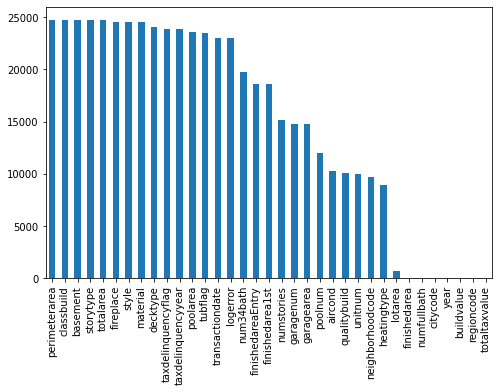

In [217]:
# Report missing data
print('Missing Values per Column:')
missing = train_raw.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
#missing.head(30)
missing.plot.bar(figsize = (8,5))

**Step 2: Remove features with missing data and deal with observations that have missing data**

I remove the columns 'totaltaxvalue', 'buildvalue' and 'landvalue' from the training set as these are highly correlated with the final values we want to predict.
The column 'mypointer' is removed from the training set as this does not feature in the test set.

In [218]:
train_clean = train_raw.copy()

In [219]:
train_clean.drop(columns=['totaltaxvalue', 'buildvalue', 'landvalue', 'mypointer'], inplace=True)
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24755 entries, 0 to 24754
Data columns (total 44 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lotid               24755 non-null  int64  
 1   logerror            1763 non-null   float64
 2   transactiondate     1763 non-null   object 
 3   aircond             14464 non-null  float64
 4   style               233 non-null    float64
 5   basement            56 non-null     float64
 6   numbath             24755 non-null  float64
 7   numbedroom          24755 non-null  int64  
 8   classbuild          18 non-null     float64
 9   qualitybuild        14654 non-null  float64
 10  decktype            712 non-null    float64
 11  finishedarea1st     6143 non-null   float64
 12  finishedarea        24692 non-null  float64
 13  perimeterarea       0 non-null      float64
 14  totalarea           62 non-null     float64
 15  finishedareaEntry   6143 non-null   float64
 16  coun

In [220]:
# Remove data that has more than 40% of missing data in training set
mypercentagevalid = 0.6
train_clean = train_clean.dropna(axis=1, thresh=round(mypercentagevalid*len(train_clean.index)))
train_clean.info()

# Save remaining columns to later apply them to test set
# Drop 'parcelvalue' as this is the dependent variable and thus does not feature in test set
regressors = train_clean.columns.drop('parcelvalue')
print(regressors)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24755 entries, 0 to 24754
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             24755 non-null  int64  
 1   numbath           24755 non-null  float64
 2   numbedroom        24755 non-null  int64  
 3   finishedarea      24692 non-null  float64
 4   countycode        24755 non-null  int64  
 5   numfireplace      24755 non-null  int64  
 6   numfullbath       24719 non-null  float64
 7   heatingtype       15789 non-null  float64
 8   latitude          24755 non-null  int64  
 9   longitude         24755 non-null  int64  
 10  lotarea           24046 non-null  float64
 11  citycode          24724 non-null  float64
 12  countycode2       24755 non-null  int64  
 13  neighborhoodcode  15027 non-null  float64
 14  regioncode        24753 non-null  float64
 15  roomnum           24755 non-null  int64  
 16  year              24743 non-null  float6

**Dealing with missing observations**

*Alternative 1: Remove all missing observations*

In [221]:
# Remove observations that have missing data
#train_clean = train_clean.dropna(axis = 0)
#train_clean.info()

*Alternative 2: Fill missing values*

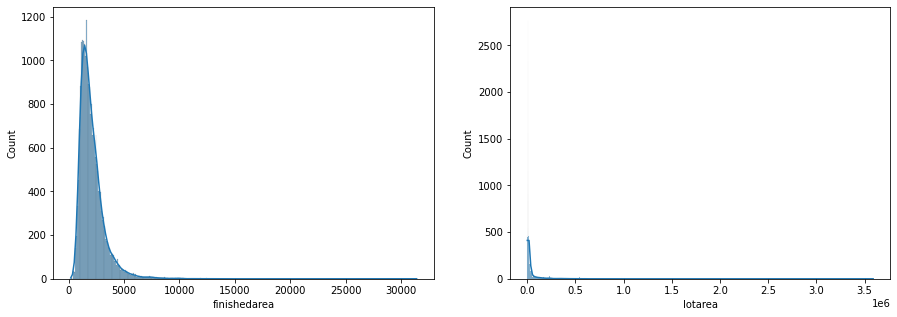

In [222]:
# Look at the distributions of numerical variables that feature missing values
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=train_clean, x="finishedarea", kde=True, ax=axs[0])
sns.histplot(data=train_clean, x="lotarea", kde=True, ax=axs[1])

plt.show()

We see that both 'finishedarea' and 'lotarea' have a positively skewed distribution. I thus decide to replace missing values with the median rather than the mean to reduce the impact of outliers.

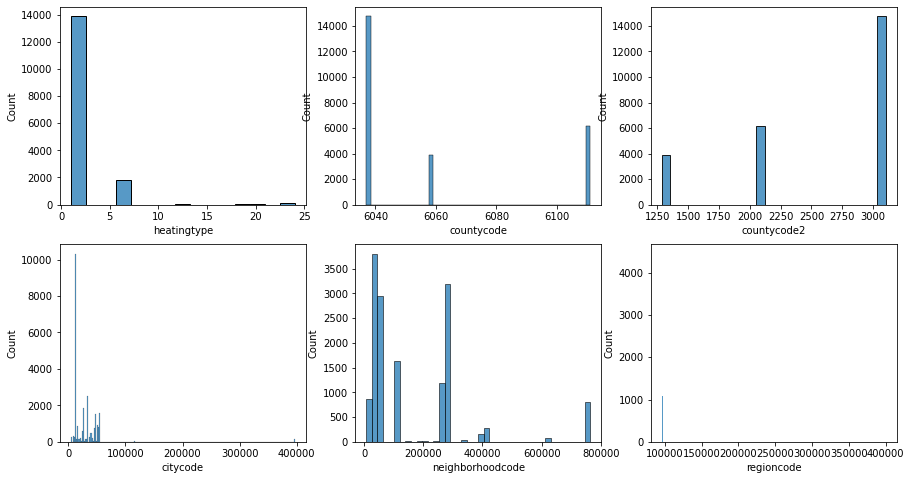

In [223]:
# Look at the distributions of categorical variables that feature missing values
fig, axs = plt.subplots(2, 3, figsize=(15, 8))

sns.histplot(data=train_clean, x="heatingtype", kde=False, ax=axs[0, 0])
sns.histplot(data=train_clean, x="countycode", kde=False, ax=axs[0, 1])
sns.histplot(data=train_clean, x="countycode2", kde=False, ax=axs[0, 2])
sns.histplot(data=train_clean, x="citycode", kde=False, ax=axs[1, 0])
sns.histplot(data=train_clean, x="neighborhoodcode", kde=False, ax=axs[1, 1])
sns.histplot(data=train_clean, x="regioncode", kde=False, ax=axs[1, 2])

plt.show()

Looking at the histograms of the categorical variables we can see that all variables except for 'neighborhoodcode' have one dominant category. I replace missing values with the value of this most frequent category. Note that this approach will skew the data as the importance of the most frequent category is overstated. Whilst this approach is less problematic for categorical variables which have few categories and feature one dominant category, it highly impacts the data for categorical data where observations are spread more evenly across multiple categories. This is the case with 'neighborhoodcode'. Hence, I refrain from applying this approach  to 'neighborhoodcode' as it would drastically overstate the significance of one particular neighbourhood. Instead I attempt to deduce the nieghborhoodcode from the variables 'latitude' and 'longitude' and drop all remaining missing observations for this variable. 

In [224]:
# Convert categorical data to strings
train_clean[['countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']] = train_clean[['countycode', 'heatingtype', 'countycode2', 'citycode', 'regioncode', 'neighborhoodcode']].astype(str).replace('nan',np.nan)

# Numerical variables: Replace missing values with median
for var in ['finishedarea', 'lotarea']:
  train_clean[var]=train_clean[var].fillna(train_clean[var].median())

# Categorical variables: Replace missing values with most frequent value
for var in ['heatingtype','numfullbath', 'citycode', 'regioncode', 'year']:
  train_clean[var]=train_clean[var].fillna(train_clean[var].value_counts().idxmax())

# For neighborhoodcode, drop all missing values - this removes a lot of data
#train_clean = train_clean.dropna()
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24755 entries, 0 to 24754
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             24755 non-null  int64  
 1   numbath           24755 non-null  float64
 2   numbedroom        24755 non-null  int64  
 3   finishedarea      24755 non-null  float64
 4   countycode        24755 non-null  object 
 5   numfireplace      24755 non-null  int64  
 6   numfullbath       24755 non-null  float64
 7   heatingtype       24755 non-null  object 
 8   latitude          24755 non-null  int64  
 9   longitude         24755 non-null  int64  
 10  lotarea           24755 non-null  float64
 11  citycode          24755 non-null  object 
 12  countycode2       24755 non-null  object 
 13  neighborhoodcode  15027 non-null  object 
 14  regioncode        24755 non-null  object 
 15  roomnum           24755 non-null  int64  
 16  year              24755 non-null  float6

In [225]:
# Alternatives
# 1. Deduce neighbourhoodcode from latitude and longitude
# 2. Use nearest neighbour matching to fill missing values - didn't have the time to read into that


# Recover some neighbourhoodcodes using latitude and longitude
# Create a list of neighbourhoods from the sample with their estimated max and min longitude and latitude
ncodes = train_clean[['neighborhoodcode', 'latitude', 'longitude']].sort_values('neighborhoodcode')
ncodes = ncodes.groupby('neighborhoodcode')
ncodes = ncodes.agg({'latitude' : [np.min, np.max], 'longitude' : [np.min, np.max]})
ncodes = ncodes.reset_index(0)
ncodes.columns = ncodes.columns.droplevel()
ncodes.columns = ['neighborhoodcode', 'amin latitude', 'amax latitude', 'amin longitude', 'amax longitude']
   
# For observations with missing values, check if latitude and longitude boundaries are assigned to a neighborhood
# if yes, replace missing value by corresponding neighborhood
lm = []
for index, row in train_clean.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    newcode = ncodes[((ncodes['amin latitude'] <= latitude) & (ncodes['amax latitude'] >= latitude)) &
                 ((ncodes['amin longitude'] <= longitude) & (ncodes['amax longitude'] >= longitude))]['neighborhoodcode'].to_list()
    if len(newcode)==0:
        lm.append(None)
    else:
        lm.append(max(newcode))                  
train_clean["newcode"] = lm

train_clean['neighborhoodcode'].fillna(train_clean['newcode'], inplace=True)
del train_clean['newcode']

train_clean.info()

# Drop remaining missing values
train_clean = train_clean.dropna()
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24755 entries, 0 to 24754
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lotid             24755 non-null  int64  
 1   numbath           24755 non-null  float64
 2   numbedroom        24755 non-null  int64  
 3   finishedarea      24755 non-null  float64
 4   countycode        24755 non-null  object 
 5   numfireplace      24755 non-null  int64  
 6   numfullbath       24755 non-null  float64
 7   heatingtype       24755 non-null  object 
 8   latitude          24755 non-null  int64  
 9   longitude         24755 non-null  int64  
 10  lotarea           24755 non-null  float64
 11  citycode          24755 non-null  object 
 12  countycode2       24755 non-null  object 
 13  neighborhoodcode  16385 non-null  object 
 14  regioncode        24755 non-null  object 
 15  roomnum           24755 non-null  int64  
 16  year              24755 non-null  float6

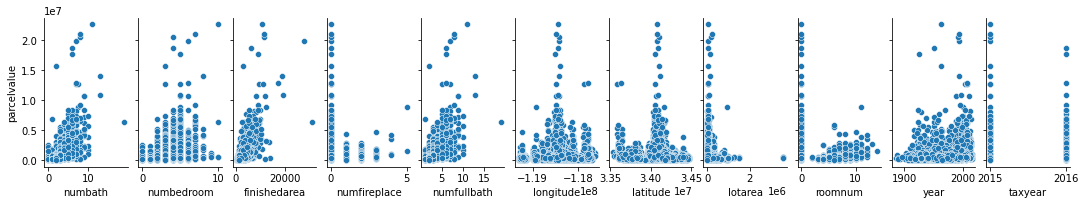

In [226]:
scatplot = sns.pairplot(train_clean, 
                        y_vars = 'parcelvalue', 
                        x_vars = ['numbath', 'numbedroom', 'finishedarea', 'numfireplace', 'numfullbath','longitude', 
                                  'latitude', 'lotarea', 'roomnum', 'year', 'taxyear'])
scatplot.fig.set_size_inches(15,3)
plt.show()

The scatterplots of our regressors against the dependent variable 'parcelvalue' show that we have some non-linear relationships in our dataset. Some can be attributed to the depedent variable being categorical and can be taken care of using dummies. For numerical variables, we may have to adjust the affected variables using polynomial- or log/sqrt-transformations. This applies to the variables 'longitude', 'latitude', 'lotarea' and potentially 'finishedarea'. I deal with this in ***Version 3*** of my model.

#Version 1: Simple Linear Regression with initial columns

Here I create a baseline model with no feature manipulation, which I will compare any subsequent models to.

In [227]:
# Check shape of dataframe
train_clean.shape

(16385, 19)

In [228]:
# Create variables
y1 = train_clean['parcelvalue']
y1 = np.array(y1).reshape(-1, 1)

X1 = train_clean.drop(columns=['parcelvalue'])
X1 = np.array(X1).reshape(16385, -1)

#X1.shape
#y1.shape

In [229]:
# Fitting simple linear regression to training data set
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X1,y1)

# Predicting the prices
y1_pred = regr.predict(X1)

Step 5: Assess expected accuracy

Text(0.5, 1.0, 'R-squared equals 0.4960632327')

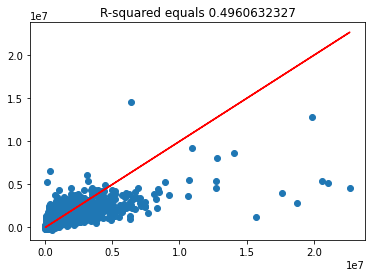

In [230]:
# Check in-sample performance
plt.figure()
plt.scatter(x=y1, y=y1_pred) 
plt.plot(y1,y1,c="red")
rho2 = sklearn.metrics.r2_score(y1,y1_pred)
plt.title('R-squared equals %.10f' % rho2)

#Version 2: Linear Regression with dummies for categorical variables

In [231]:
train_dummies = train_clean.copy()

**Step 3: Create dummies for relevant features**

I get dummies for all categorical variables. This includes: 

*   regional codes
* 'heatingtype'
* 'taxyear'
*  discrete numerical variables such as 'numbath', 'numbedroom' etc.

I include discrete variables in my list of dummies in order to avoid the problem of potential non-linearities.

In [232]:
# Get dummies for categorical variables
train_dummies = pd.get_dummies(train_dummies, columns=['countycode', 'heatingtype', 'countycode2', 'citycode', 
                                                       'regioncode', 'neighborhoodcode', 'numbath', 'numbedroom', 
                                                       'numfireplace', 'numfullbath', 'roomnum', 'taxyear'], 
                               drop_first=True)
train_dummies.head()

,lotid,finishedarea,latitude,longitude,lotarea,year,parcelvalue,countycode_6059,countycode_6111,heatingtype_13.0,heatingtype_14.0,heatingtype_18.0,heatingtype_2.0,heatingtype_20.0,heatingtype_24.0,heatingtype_6.0,heatingtype_7.0,countycode2_2061,countycode2_3101,citycode_10608.0,citycode_10723.0,citycode_116042.0,citycode_118878.0,citycode_118994.0,citycode_12292.0,citycode_12447.0,citycode_12520.0,citycode_13150.0,citycode_16764.0,citycode_21412.0,citycode_24174.0,citycode_24812.0,citycode_24832.0,citycode_26531.0,citycode_26964.0,citycode_27183.0,citycode_30187.0,citycode_30908.0,citycode_33252.0,citycode_33311.0,...,numbedroom_2,numbedroom_3,numbedroom_4,numbedroom_5,numbedroom_6,numbedroom_7,numbedroom_8,numbedroom_9,numbedroom_10,numfireplace_1,numfireplace_2,numfireplace_3,numfireplace_4,numfireplace_5,numfullbath_2.0,numfullbath_3.0,numfullbath_4.0,numfullbath_5.0,numfullbath_6.0,numfullbath_7.0,numfullbath_8.0,numfullbath_9.0,numfullbath_10.0,numfullbath_11.0,numfullbath_13.0,numfullbath_19.0,roomnum_2,roomnum_3,roomnum_4,roomnum_5,roomnum_6,roomnum_7,roomnum_8,roomnum_9,roomnum_10,roomnum_11,roomnum_12,roomnum_13,roomnum_14,taxyear_2016
0,17214744,1255.0,34191029,-118914689,12497.0,1979.0,142212.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,12018724,1033.0,34092200,-118374000,20527.0,1973.0,301141.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,11047729,1757.0,34252019,-118467570,8612.0,1952.0,270543.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,14305657,1641.0,33681662,-117802630,4986.0,1976.0,671269.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,11016338,1663.0,34284508,-118493574,12102.0,1961.0,363524.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [233]:
train_dummies.shape

(16385, 828)

In [234]:
train_dummies.columns

Index(['lotid', 'finishedarea', 'latitude', 'longitude', 'lotarea', 'year',
       'parcelvalue', 'countycode_6059', 'countycode_6111', 'heatingtype_13.0',
       ...
       'roomnum_6', 'roomnum_7', 'roomnum_8', 'roomnum_9', 'roomnum_10',
       'roomnum_11', 'roomnum_12', 'roomnum_13', 'roomnum_14', 'taxyear_2016'],
      dtype='object', length=828)

# *Version A: Simple Linear Regression*

**Step 4: Build your model and get predictions from train data**

In [235]:
# Create variables
y2 = train_dummies['parcelvalue']
y2 = np.array(y2).reshape(-1, 1)

X2 = train_dummies.drop(columns=['parcelvalue'])
X2 = np.array(X2).reshape(16385, -1)

#X2.shape
#y2.shape

In [236]:
# Fitting simple linear regression to training data set
regr.fit(X2, y2)

# Predicting the prices
y2_pred = regr.predict(X2)

**Step 5: Assess expected accuracy**

Text(0.5, 1.0, 'R-squared equals 0.6434448960')

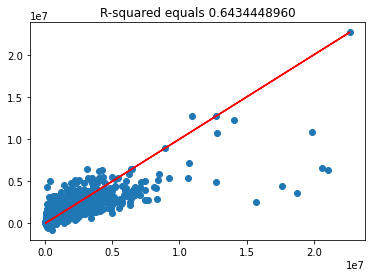

In [237]:
# Check in-sample performance
plt.figure()
plt.scatter(x=y2, y=y2_pred) 
plt.plot(y2,y2,c="red")
rho2 = sklearn.metrics.r2_score(y2,y2_pred)
plt.title('R-squared equals %.10f' % rho2)

# *Version B: Lasso Regression*
    
**Step 4: Build your model and get predictions from train data**

In [238]:
# Standardisation of predictors
from sklearn import preprocessing
scaler = preprocessing.StandardScaler() ## Instantiate scaler
scaler.fit(X2) ## Fit to training set
X2 = scaler.transform(X2)

In [239]:
# LASSO regression with AIC criterion
from sklearn.linear_model import LassoLarsIC
regr_aic = LassoLarsIC(criterion="aic", normalize=False, max_iter=10000)
regr_aic.fit(X2, y2)
alpha2_aic = regr_aic.alpha_
print("Alpha:", alpha2_aic)
#print(regr_aic.coef_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha: 26998.77553004444


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 29 iterations, i.e. alpha=2.891e+04, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=2.700e+04, previous alpha=2.665e+04, with an active set of 35 regressors.
  ConvergenceWarning)


**Step 5: Assess expected accuracy**

Text(0.5, 1.0, 'R-squared equals 0.5869954615')

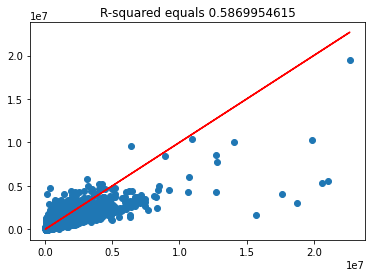

In [240]:
# In-sample
y2_pred_aic = regr_aic.predict(X2)

plt.figure()
plt.scatter(x=y2, y=y2_pred_aic) 
plt.plot(y2,y2,c="red")
rho2 = sklearn.metrics.r2_score(y2,y2_pred_aic)
plt.title('R-squared equals %.10f' % rho2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 27 iterations, alpha=3.466e+04, previous alpha=3.465e+04, with an active set of 28 regressors.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropp

Text(0.5, 1.0, 'R-squared equals 0.5391273447')

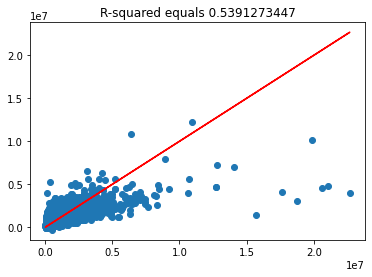

In [241]:
# Out-of-sample
from sklearn.model_selection import cross_val_predict as cvp

y2_pred_cv = cvp(regr_aic, X2, y2, cv=5)

plt.figure()
plt.scatter(x=y2,y=y2_pred_cv) 
plt.plot(y2,y2,c="red")
rho2 = sklearn.metrics.r2_score(y2,y2_pred_cv)
plt.title('R-squared equals %.10f' %rho2)

**Step 6: Report variable impact**

In [242]:
# Create DataFrame of regression outputs
var = list(train_dummies.columns)
beta = list(regr_aic.coef_)
coef_tuples = list(zip(var,beta))
coef_df = pd.DataFrame(coef_tuples, columns=['Feature','Coefficient'])
coef_df = coef_df[coef_df['Coefficient'] != 0]
coef_df.sort_values(by=['Coefficient'], key=pd.Series.abs, inplace=True, ascending=False, ignore_index=True)

print("The 5 most impactful variables are:")
coef_df.head(5)


The 5 most impactful variables are:


,Feature,Coefficient
0,finishedarea,412119.239892
1,numbath_10.0,117040.984410
2,neighborhoodcode_113886.0,72598.873154
3,regioncode_96116.0,47876.210714
4,regioncode_96072.0,47638.436951


# Version 3: Linear Regression with polynomial and log transformations

The histogram of 'parcelvalue' does not show a normal distribution but is positively skewed. This indicates that the fit might be improved by taking the log or squareroot of parcelvalue.

Similarly, we find non-linear relationships between our dependent variable and some of the regressors, as shown in the data exploration section.

I transform these regressors to see if this improves my predictions.

In [243]:
train_new = train_dummies.copy()

[Text(0.5, 1.0, "Density plot of 'parcelvalue'")]

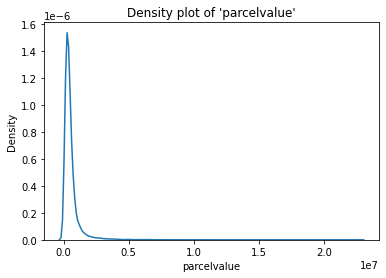

In [244]:
# Create a density plot of 'parcelvalue'
sns.kdeplot(data=train_new, x="parcelvalue").set(title="Density plot of 'parcelvalue'")
# 'parcelvalue' is not normally distributed, but positively skewed

[Text(0.5, 1.0, "Density plot of the squareroot of 'parcelvalue'")]

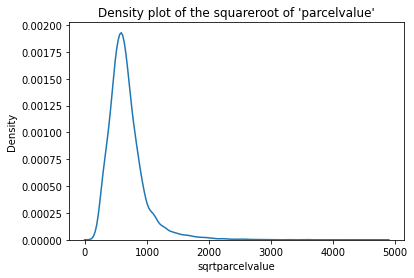

In [245]:
# Adjust to logs/sqrt to remove skewness of dependent variable

#train_new['logparcelvalue'] = np.log(train_new['parcelvalue']) ## sqrt and linear perform better
train_new['sqrtparcelvalue'] = np.sqrt(train_new['parcelvalue']) ## this model performs best

#sns.kdeplot(data=train_new, x="logparcelvalue")
# we see that logparcelvalue resembles a normal distribution

sns.kdeplot(data=train_new, x="sqrtparcelvalue").set(title="Density plot of the squareroot of 'parcelvalue'")
# taking the sqrt of parcelvalue removes some of the skewness but the distribution remains positively skewed

In [246]:
train_new['latitude2'] = train_new['latitude']**2
train_new['longitude2'] = train_new['longitude']**2
#train_new['loglotarea'] = np.log(train_new['lotarea']) ## sqrt performs better
train_new['sqrtlotarea'] = np.sqrt(train_new['lotarea'])
#train_new['logfinishedarea'] = np.log(train_new['finishedarea']) ## linear performs better
#train_new['sqrtfinishedarea'] = np.sqrt(train_new['finishedarea'])

train_new = train_new.drop(columns=['parcelvalue', 'lotarea'])
#train_new = train_new.drop(columns=['parcelvalue', 'lotarea', 'finishedarea'])

train_new.head()

,lotid,finishedarea,latitude,longitude,year,countycode_6059,countycode_6111,heatingtype_13.0,heatingtype_14.0,heatingtype_18.0,heatingtype_2.0,heatingtype_20.0,heatingtype_24.0,heatingtype_6.0,heatingtype_7.0,countycode2_2061,countycode2_3101,citycode_10608.0,citycode_10723.0,citycode_116042.0,citycode_118878.0,citycode_118994.0,citycode_12292.0,citycode_12447.0,citycode_12520.0,citycode_13150.0,citycode_16764.0,citycode_21412.0,citycode_24174.0,citycode_24812.0,citycode_24832.0,citycode_26531.0,citycode_26964.0,citycode_27183.0,citycode_30187.0,citycode_30908.0,citycode_33252.0,citycode_33311.0,citycode_33612.0,citycode_34278.0,...,numbedroom_6,numbedroom_7,numbedroom_8,numbedroom_9,numbedroom_10,numfireplace_1,numfireplace_2,numfireplace_3,numfireplace_4,numfireplace_5,numfullbath_2.0,numfullbath_3.0,numfullbath_4.0,numfullbath_5.0,numfullbath_6.0,numfullbath_7.0,numfullbath_8.0,numfullbath_9.0,numfullbath_10.0,numfullbath_11.0,numfullbath_13.0,numfullbath_19.0,roomnum_2,roomnum_3,roomnum_4,roomnum_5,roomnum_6,roomnum_7,roomnum_8,roomnum_9,roomnum_10,roomnum_11,roomnum_12,roomnum_13,roomnum_14,taxyear_2016,sqrtparcelvalue,latitude2,longitude2,sqrtlotarea
0,17214744,1255.0,34191029,-118914689,1979.0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,377.110064,1169026464078841,14140703259966721,111.789982
1,12018724,1033.0,34092200,-118374000,1973.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,548.763155,1162278100840000,14012403876000000,143.272468
3,11047729,1757.0,34252019,-118467570,1952.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,520.137482,1173200805576361,14034565141704900,92.800862
5,14305657,1641.0,33681662,-117802630,1976.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,819.310076,1134454355082244,13877459634916900,70.611614
6,11016338,1663.0,34284508,-118493574,1961.0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,602.929515,1175427488802064,14040727079293476,110.009091


**Step 4: Build your model and get predictions from train data**

In [247]:
# Create variables
#y3 = train_new['logparcelvalue']
y3 = train_new['sqrtparcelvalue']
y3 = np.array(y3).reshape(-1, 1)

#X3 = train_new.drop(columns=['logparcelvalue'])
X3 = train_new.drop(columns=['sqrtparcelvalue'])
X3 = np.array(X3).reshape(16385, -1)
X3.shape

(16385, 829)

In [248]:
# Standardise predictors
scaler.fit(X3)## Fit to training set
X3 = scaler.transform(X3)

regr_aic = LassoLarsIC(criterion="aic", normalize=False, max_iter=10000)
regr_aic.fit(X3, y3)
alpha3_aic = regr_aic.alpha_
print("Alpha:", alpha3_aic)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha: 4.198353161296117


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:608: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 124 iterations, alpha=4.198e+00, previous alpha=4.192e+00, with an active set of 121 regressors.
  ConvergenceWarning)


**Step 5: Assess expected accuracy**

Text(0.5, 1.0, 'R-squared equals 0.6359678182')

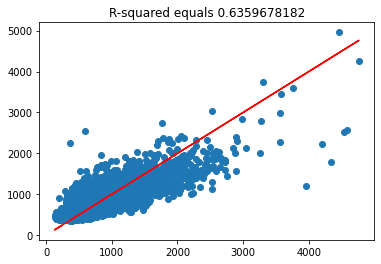

In [249]:
# In-sample
y3_pred_aic = regr_aic.predict(X3)

plt.figure()
plt.scatter(x=y3, y=y3_pred_aic) 
plt.plot(y3,y3,c="red")
rho2 = sklearn.metrics.r2_score(y3,y3_pred_aic)
plt.title('R-squared equals %.10f' % rho2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=2.789e+01, with an active set of 7 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:582: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=1.432e+01, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/usr/local/lib/

Text(0.5, 1.0, 'R-squared equals 0.5968268185')

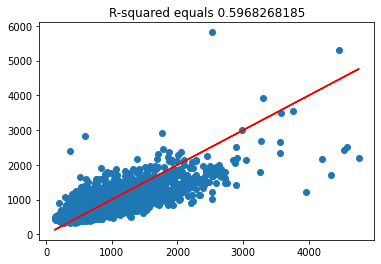

In [250]:
# Out-of-sample
y3_pred_cv = cvp(regr_aic, X3, y3, cv=5)

plt.figure()
plt.scatter(x=y3,y=y3_pred_cv) 
plt.plot(y3,y3,c="red")
rho2 = sklearn.metrics.r2_score(y3,y3_pred_cv)
plt.title('R-squared equals %.10f' %rho2)

**Step 6: Report variable impact**

In [251]:
# Create DataFrame of regression outputs
var3 = list(train_new.columns)
beta3 = list(regr_aic.coef_)
coef3_tuples = list(zip(var3,beta3))
coef3_df = pd.DataFrame(coef3_tuples, columns=['Feature','Coefficient'])
coef3_df = coef3_df[coef3_df['Coefficient'] != 0]
coef3_df.sort_values(by=['Coefficient'], key=pd.Series.abs, inplace=True, ascending=False, ignore_index=True)

print("The 5 most impactful variables are:")
coef3_df.head(5)

The 5 most impactful variables are:


,Feature,Coefficient
0,finishedarea,185.659089
1,neighborhoodcode_113910.0,34.559254
2,neighborhoodcode_274049.0,24.234656
3,neighborhoodcode_19810.0,22.187270
4,numbath_19.0,-18.336947


# *Refine the model using Lasso GridSearch*

In [252]:
# Choosing the regularisation parameter
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

# instantiate the lasso model
lasso = Lasso(random_state=0,max_iter=50000) 

# specify grid values that I want to search over
alphas = np.array([0.05, 0.5, 5, 50, 500])
tuned_parameters = [{'alpha': alphas}]

# create scorer to evaluate performance
from sklearn.metrics import mean_squared_error, make_scorer 
rmse = make_scorer(mean_squared_error,squared=False,greater_is_better=False)

In [253]:
# instantiate GridSearchCV
n_folds = 5
clf = GridSearchCV(lasso, tuned_parameters, scoring = rmse, 
                   cv=n_folds, refit=False)

# train using training data
clf.fit(X3, y3)

scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
std_error = scores_std / np.sqrt(n_folds)

# Extract best parameters
clf.best_params_

{'alpha': 0.5}

(0.05, 500.0)

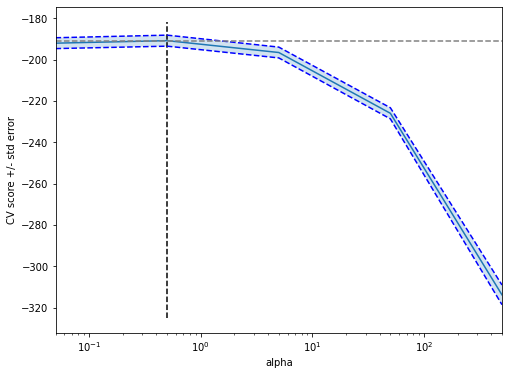

In [254]:
# Plotting the results

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
ymin, ymax = plt.ylim()
plt.vlines(clf.best_params_['alpha'] ,ymin, ymax, linestyle='dashed')
plt.xlim([alphas[0], alphas[-1]])

In [255]:
# LASSO regression
regr_lasso = Lasso(alpha=0.5, fit_intercept=True, warm_start=True, normalize = False, max_iter=10000) ## instantiate Lasso
regr_lasso.fit(X3, y3) ## fit model
#print(regr_lasso.coef_)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=True)

**Step 5: Assess expected accuracy**

Text(0.5, 1.0, 'R-squared equals 0.6685989722')

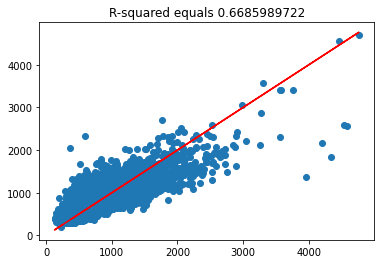

In [256]:
# In-sample
y3_pred_lasso = regr_lasso.predict(X3)

plt.figure()
plt.scatter(x=y3, y=y3_pred_lasso) 
plt.plot(y3,y3,c="red")
rho2 = sklearn.metrics.r2_score(y3,y3_pred_lasso)
plt.title('R-squared equals %.10f' % rho2)

Text(0.5, 1.0, 'R-squared equals 0.6300897899')

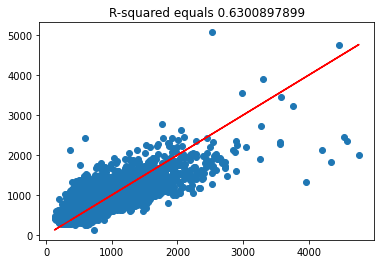

In [257]:
# Out-of-sample
y3_pred_cv = cvp(regr_lasso, X3, y3, cv=5)

plt.figure()
plt.scatter(x=y3,y=y3_pred_cv) 
plt.plot(y3,y3,c="red")
rho2 = sklearn.metrics.r2_score(y3,y3_pred_cv)
plt.title('R-squared equals %.10f' %rho2)

**Step 6: Report variable impact**

In [258]:
# Create DataFrame of regression outputs
var3 = list(train_new.columns)
beta3 = list(regr_lasso.coef_)
coef3_tuples = list(zip(var3,beta3))
coef3_df = pd.DataFrame(coef3_tuples, columns=['Feature','Coefficient'])
coef3_df = coef3_df[coef3_df['Coefficient'] != 0]
coef3_df.sort_values(by=['Coefficient'], key=pd.Series.abs, inplace=True, ascending=False, ignore_index=True)

print("The 5 most impactful variables are:")
coef3_df.head(5)

The 5 most impactful variables are:


,Feature,Coefficient
0,finishedarea,162.362300
1,neighborhoodcode_113910.0,37.140739
2,regioncode_96050.0,29.793521
3,regioncode_96120.0,29.357713
4,regioncode_96149.0,29.337309


**Step 7: Prepare code to run and check performance of your model using a new input data with same exact format**

In [259]:
# Load data
test_raw = pd.read_csv("Regression_Supervised_Test.csv")

# Overview of the data
# test_raw.info()
test_raw.head()
# test_raw.duplicated().sum() ## no duplicates found


,lotid,logerror,transactiondate,aircond,style,basement,numbath,numbedroom,classbuild,qualitybuild,decktype,finishedarea1st,finishedarea,perimeterarea,totalarea,finishedareaEntry,countycode,numfireplace,numfullbath,garagenum,garagearea,tubflag,heatingtype,latitude,longitude,lotarea,poolnum,poolarea,citycode,countycode2,neighborhoodcode,regioncode,roomnum,storytype,num34bath,material,unitnum,year,numstories,fireplace,buildvalue,taxyear,landvalue,totaltaxvalue,taxdelinquencyflag,taxdelinquencyyear
0,11614222,NaN,NaN,1.0,NaN,NaN,3.0,3,NaN,4.0,NaN,NaN,1618.0,NaN,NaN,NaN,6037,0,3.0,NaN,NaN,NaN,2.0,34048500,-118438000,19423.0,NaN,NaN,12447.0,3101,118887.0,96006,0,NaN,NaN,NaN,1.0,1975.0,NaN,NaN,165179.0,2015,286865.0,5517.93,NaN,NaN
1,11555888,NaN,NaN,NaN,NaN,NaN,2.0,3,NaN,4.0,NaN,NaN,1817.0,NaN,NaN,NaN,6037,0,2.0,NaN,NaN,NaN,2.0,34023816,-118429617,7625.0,1.0,NaN,12447.0,3101,116415.0,96047,0,NaN,NaN,NaN,1.0,1948.0,NaN,NaN,295765.0,2015,202798.0,6188.97,NaN,NaN
2,13052987,NaN,NaN,1.0,NaN,NaN,2.0,3,NaN,8.0,NaN,NaN,1549.0,NaN,NaN,NaN,6037,0,2.0,NaN,NaN,NaN,2.0,34125379,-117707983,11080.0,1.0,NaN,30908.0,3101,764142.0,96469,0,NaN,NaN,NaN,1.0,1978.0,NaN,NaN,110977.0,2016,225109.0,4245.09,NaN,NaN
3,12448473,NaN,NaN,1.0,NaN,NaN,3.0,3,NaN,4.0,NaN,NaN,1275.0,NaN,NaN,NaN,6037,0,3.0,NaN,NaN,NaN,2.0,33878735,-118171388,58881.0,NaN,NaN,46298.0,3101,276476.0,96239,0,NaN,NaN,NaN,1.0,1991.0,NaN,NaN,146117.0,2015,69522.0,2739.32,NaN,NaN
4,12559155,NaN,NaN,1.0,NaN,NaN,1.0,1,NaN,NaN,NaN,NaN,600.0,NaN,NaN,NaN,6037,0,1.0,NaN,NaN,NaN,2.0,33766300,-118188000,47343.0,1.0,NaN,46298.0,3101,273486.0,96236,0,NaN,NaN,NaN,1.0,2004.0,NaN,NaN,183656.0,2015,122438.0,3824.87,NaN,NaN


In [260]:
# Remove columns 'totaltaxvalue', 'buildvalue' or 'landvalue' from the test set
test_clean = test_raw.drop(columns=['totaltaxvalue', 'buildvalue', 'landvalue'])

# Remove columns with large number of missing values
test_clean = test_clean[regressors]

In [261]:
# Deal with missing values
# Report missing data
print('Missing Values per Column:')
test_clean.isnull().sum().sort_values(ascending=False).head(25)
# no missing values

Missing Values per Column:


taxyear             0
year                0
numbath             0
numbedroom          0
finishedarea        0
countycode          0
numfireplace        0
numfullbath         0
heatingtype         0
latitude            0
longitude           0
lotarea             0
citycode            0
countycode2         0
neighborhoodcode    0
regioncode          0
roomnum             0
lotid               0
dtype: int64

In [262]:
test_dummies = test_clean.copy()

In [263]:
# Get dummies
test_dummies = pd.get_dummies(test_dummies, columns=['countycode', 'heatingtype', 'countycode2', 'citycode', 
                                                       'regioncode', 'neighborhoodcode', 'numbath', 'numbedroom', 
                                                       'numfireplace', 'numfullbath', 'roomnum', 'taxyear'], 
                               drop_first=True)

test_dummies.head()

,lotid,finishedarea,latitude,longitude,lotarea,year,countycode_6059,heatingtype_6.0,heatingtype_7.0,heatingtype_20.0,countycode2_3101,citycode_12447.0,citycode_12520.0,citycode_16764.0,citycode_26964.0,citycode_30908.0,citycode_33612.0,citycode_37688.0,citycode_39308.0,citycode_42150.0,citycode_45457.0,citycode_46298.0,citycode_47019.0,citycode_47568.0,citycode_48424.0,citycode_51617.0,citycode_51861.0,citycode_52650.0,citycode_54299.0,citycode_54311.0,citycode_54722.0,citycode_396054.0,regioncode_95983,regioncode_95984,regioncode_95985,regioncode_95986,regioncode_95987,regioncode_95988,regioncode_95989,regioncode_95991,...,neighborhoodcode_764099.0,neighborhoodcode_764134.0,neighborhoodcode_764135.0,neighborhoodcode_764138.0,neighborhoodcode_764140.0,neighborhoodcode_764142.0,neighborhoodcode_764147.0,neighborhoodcode_764148.0,neighborhoodcode_764166.0,numbath_1.5,numbath_2.0,numbath_2.5,numbath_3.0,numbath_4.0,numbath_5.0,numbath_6.0,numbath_7.0,numbath_8.0,numbath_9.0,numbedroom_1,numbedroom_2,numbedroom_3,numbedroom_4,numbedroom_5,numbedroom_6,numbedroom_7,numbedroom_8,numfireplace_1,numfullbath_2.0,numfullbath_3.0,numfullbath_4.0,numfullbath_5.0,numfullbath_6.0,numfullbath_7.0,numfullbath_8.0,numfullbath_9.0,roomnum_5,roomnum_6,roomnum_7,taxyear_2016
0,11614222,1618.0,34048500,-118438000,19423.0,1975.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,11555888,1817.0,34023816,-118429617,7625.0,1948.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,13052987,1549.0,34125379,-117707983,11080.0,1978.0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,12448473,1275.0,33878735,-118171388,58881.0,1991.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,12559155,600.0,33766300,-118188000,47343.0,2004.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [264]:
# Ensure that columns in training and test set are the same by creating the missing columns
# and setting them equal to a vector of zeros
missing_cols = set(train_dummies.columns) - set(test_dummies.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
  test_dummies[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
test_dummies = test_dummies[train_dummies.columns]
test_dummies = test_dummies.drop(columns=['parcelvalue'])

test_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2746 entries, 0 to 2745
Columns: 827 entries, lotid to taxyear_2016
dtypes: float64(3), int64(519), uint8(305)
memory usage: 11.7 MB


In [265]:
test_dummies.head()

,lotid,finishedarea,latitude,longitude,lotarea,year,countycode_6059,countycode_6111,heatingtype_13.0,heatingtype_14.0,heatingtype_18.0,heatingtype_2.0,heatingtype_20.0,heatingtype_24.0,heatingtype_6.0,heatingtype_7.0,countycode2_2061,countycode2_3101,citycode_10608.0,citycode_10723.0,citycode_116042.0,citycode_118878.0,citycode_118994.0,citycode_12292.0,citycode_12447.0,citycode_12520.0,citycode_13150.0,citycode_16764.0,citycode_21412.0,citycode_24174.0,citycode_24812.0,citycode_24832.0,citycode_26531.0,citycode_26964.0,citycode_27183.0,citycode_30187.0,citycode_30908.0,citycode_33252.0,citycode_33311.0,citycode_33612.0,...,numbedroom_2,numbedroom_3,numbedroom_4,numbedroom_5,numbedroom_6,numbedroom_7,numbedroom_8,numbedroom_9,numbedroom_10,numfireplace_1,numfireplace_2,numfireplace_3,numfireplace_4,numfireplace_5,numfullbath_2.0,numfullbath_3.0,numfullbath_4.0,numfullbath_5.0,numfullbath_6.0,numfullbath_7.0,numfullbath_8.0,numfullbath_9.0,numfullbath_10.0,numfullbath_11.0,numfullbath_13.0,numfullbath_19.0,roomnum_2,roomnum_3,roomnum_4,roomnum_5,roomnum_6,roomnum_7,roomnum_8,roomnum_9,roomnum_10,roomnum_11,roomnum_12,roomnum_13,roomnum_14,taxyear_2016
0,11614222,1618.0,34048500,-118438000,19423.0,1975.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,11555888,1817.0,34023816,-118429617,7625.0,1948.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,13052987,1549.0,34125379,-117707983,11080.0,1978.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,12448473,1275.0,33878735,-118171388,58881.0,1991.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,12559155,600.0,33766300,-118188000,47343.0,2004.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [266]:
test_new = test_dummies.copy()

In [267]:
# Add logarithmic and polynomial transformations to test data
test_new['latitude2'] = test_new['latitude']**2
test_new['longitude2'] = test_new['longitude']**2
#test_new['loglotarea'] = np.log(test_new['lotarea'])
test_new['sqrtlotarea'] = np.log(test_new['lotarea'])
#test_new['logfinishedarea'] = np.log(test_new['finishedarea'])
#test_new['sqrtfinishedarea'] = np.log(test_new['finishedarea'])

test_new = test_new.drop(columns=['lotarea'])
#test_new = test_new.drop(columns=['lotarea', 'finishedarea'])

test_new.head()
test_new.shape

(2746, 829)

In [268]:
# Format data
X3_test = test_new
X3_test = np.array(X3_test).reshape(2746, 829)

# Rescale X_test
X3_test = scaler.transform(X3_test)

In [269]:
# Check performance of model on test set
#y3_hat_test = regr_lasso.predict(X3_test) ## aic performs better on test set
y3_hat_test = regr_aic.predict(X3_test)

#y3_hat_test = np.exp(y3_hat_test)
y3_hat_test = np.square(y3_hat_test)

### Kaggle Predictions Submissions

Once you have produced testset predictions you can submit these to <i> kaggle </i> in order to see how your model performs. 

The following code provides an example of generating a <i> .csv </i> file to submit to kaggle
1) create a pandas dataframe with two columns, one with the test set "lotid"'s and the other with your predicted "parcelvalue" for that observation

2) use the <i> .to_csv </i> pandas method to create a csv file. The <i> index = False </i> is important to ensure the <i> .csv </i> is in the format kaggle expects 

In [270]:
# Step 8: Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"lotid": test_new["lotid"], "parcelvalue": y3_hat_test})
test_predictions_submit.to_csv("test_predictions_submit.csv", index = False)